# 1. Interactions
Let's assume that we have a true model, as defined below
\begin{align}
y = a_0 + a_1 x_1 + a_2 x_2 + c_{12} x_1 x_2
\end{align}

1. Does adding $x_1 x_2$ as a feature improve the cross validation score ?
-> The answer appears to be yes for ET


2. Is there any way to discover systematically that features $x_1$ and $x_2$ interact with each other ?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import ExtraTreesRegressor 
X = np.random.normal(0, 3, 1000).reshape((500, 2))
X = np.concatenate([np.expand_dims(np.ones(500), axis=1), X], axis=1)
Xnoise = np.random.normal(0, 1, 5000).reshape(500, 10)
Xprime = np.concatenate([X, np.expand_dims(X[:, 1]*X[:, 2], axis=1)], 
                         axis=1)
Xwnoise = np.concatenate([X, Xnoise], 
                         axis=1)
epsilon = np.random.normal(0, 0.2, 500)
a_0 = 0.3
a_1 = 0.1
a_2 = 0.1
c_12 = 1
y = a_0 + a_1*X[:, 1] + a_2*X[:, 2] + c_12*X[:, 1]*X[:, 2] + epsilon

In [3]:
pd.DataFrame(Xprime).corr()

,0,1,2,3
0,NaN,NaN,NaN,NaN
1,NaN,1.000000,-0.022087,0.090133
2,NaN,-0.022087,1.000000,0.013265
3,NaN,0.090133,0.013265,1.000000


# Question 1:
For a random forest, is it easier to fit if we add x_1 x_2 as a feature ?

In [14]:
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.base import clone
import copy

def hbar_plot(x, err, xticks, title):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    bar_no = x.shape[0]
    plt.barh(range(bar_no), x, color='lightblue', xerr=err, align='center')
    plt.yticks(range(bar_no), xticks)
    plt.gca().invert_yaxis()
    #plt.xlim([-1, bar_no])
    plt.show()
    
def permutate_and_score(clf, X_test, y_test, i, metric_fn, **kwargs):
    X_test_ = copy.deepcopy(X_test)
    np.random.shuffle(X_test_[i])
    y_pred = clf.predict(X_test_)
    return metric_fn(y_test, clf.predict(X_test)) - metric_fn(y_test, y_pred)

def drop_refit_and_score(clf, X_test, y_test, X_train, y_train, i, metric_fn):
    X_train_ = np.delete(copy.deepcopy(X_train), i, axis=1)
    X_test_ = np.delete(copy.deepcopy(X_test), i, axis=1)
    clf_ = clone(clf)
    clf_.random_state = 0
    clf_.fit(X_train_, y_train)
    y_pred = clf_.predict(X_test_)
    return metric_fn(y_test, y_pred)

def calc_stats(dscores, colnms):
    bias_corr = (dscores.shape[0]-1.5)**-.5
    summary = pd.DataFrame([np.mean(dscores, axis=0),
                            np.std(dscores, axis=0)*bias_corr],
                            columns=colnms,
                            index=['mean', 'std'])
    summary = summary.T.sort_values('mean', ascending=False)
    return summary

def calc_mda(clf, X, y, folds, metric_fn, score_fn):
    kf = KFold(n_splits=folds, shuffle=True)
    kf.get_n_splits(X)
    decrease_scores = []
    for train, test in kf.split(X):
        clf_ = clone(clf)
        clf_.random_state = 0
        clf_.fit(X[train], y[train])
        y_pred = clf_.predict(X[test])
        base = metric_fn(y[test], y_pred)
        print(base)
        param_dict = {'clf':clf_, 'X_train': X[train], 'y_train': y[train],
                      'X_test': X[test], 'y_test':y[test],
                      'metric_fn': metric_fn}
        #decrease_scores.append([base - score_fn(**dict(param_dict, i=i)) 
        decrease_scores.append([score_fn(**dict(param_dict, i=i)) 
                                for i in range(X[train].shape[1])])
    return np.array(decrease_scores)


In [12]:
%%time
x_cols = list(range(Xwnoise.shape[1]))
rf = ExtraTreesRegressor(n_estimators=1000, max_depth=None, 
                           random_state=0, min_samples_split=10)
dscores = calc_mda(rf, Xwnoise, y, folds=10, metric_fn=metrics.r2_score, 
                   score_fn=drop_refit_and_score)
stats = calc_stats(dscores, x_cols)  
hbar_plot(stats['mean'], stats['std'], stats.index, 'Mean Decrease Accuracy')

0.8802462109781325


KeyboardInterrupt: 

0.5285990510568155
0.7717319515340133
0.8145017075095072
0.5544427368818377
0.7364735200938555
0.6908991750250166
0.7642988307327091
0.6170210284186693
0.5068955411719566
0.7643285992489312


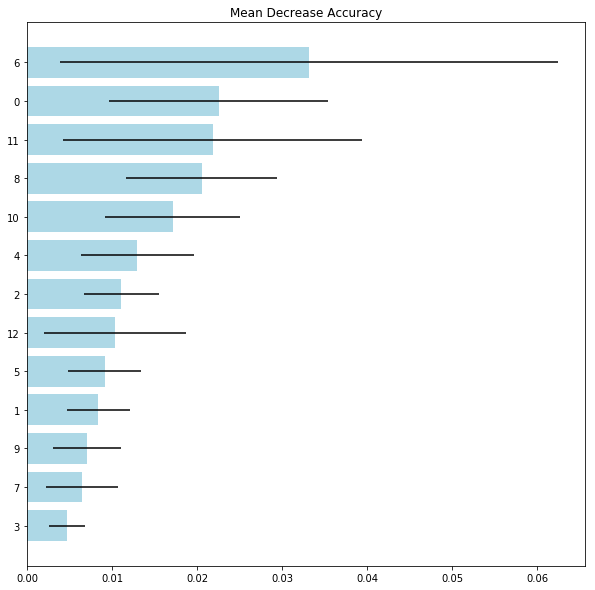

CPU times: user 28.7 s, sys: 2.48 s, total: 31.2 s
Wall time: 27.9 s


In [15]:
%%time 
x_cols = list(range(Xwnoise.shape[1]))
rf = ExtraTreesRegressor(n_estimators=1000, max_depth=None, 
                           random_state=0, min_samples_split=10)
dscores = calc_mda(rf, Xwnoise, y, folds=10, metric_fn=metrics.r2_score, 
                   score_fn=permutate_and_score)
stats = calc_stats(dscores, x_cols)  
hbar_plot(stats['mean'], stats['std'], stats.index, 'Mean Decrease Accuracy')

In [106]:
stats.assign(ratio = lambda x: x['mean']/x['std']).sort_values('ratio', ascending=False)

,mean,std,ratio
0,0.012070,0.003163,3.815704
3,0.006216,0.002234,2.782974
5,0.014763,0.005868,2.515979
12,0.010889,0.004667,2.333250
4,0.010737,0.005309,2.022488
2,0.017823,0.008986,1.983499
10,0.018472,0.009522,1.939864
6,0.041654,0.022164,1.879369
1,0.040284,0.021817,1.846427
9,0.032612,0.018926,1.723177


CPU times: user 52.3 s, sys: 0 ns, total: 52.3 s
Wall time: 52.3 s


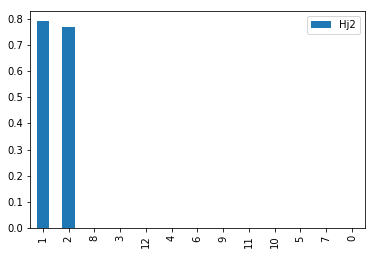

In [111]:
%%time
def lin_space_or_unique(x, lin_num):
    unique_elements = np.unique(np.sort(x))
    if unique_elements.shape[0] <= lin_num:
        X_vals = unique_elements
    else:
        X_vals = np.linspace(min(unique_elements), max(unique_elements), 
                             num=lin_num)
    return X_vals

def create_grid(X, remaining_features, lin_num):
    feature_lists = [lin_space_or_unique(X[:, idx], lin_num) for idx in 
                     remaining_features]
    x = np.meshgrid(*feature_lists)
    out = np.array([m.flatten() for m in x]).T
    return out

def pdp_fun(X_s, X, remaining_features, rf, subtract_mean=True):
    x_vals = np.vstack([X]*X_s.shape[0])
    X_s_repeat = np.repeat(X_s, X.shape[0], axis=0)
    X_s_repeat.shape
    x_vals[:, remaining_features] = X_s_repeat
    y_vals = rf.predict(x_vals)
    y_out = np.mean(y_vals.reshape(-1, X.shape[0]), axis=1)
    #x_vals = x_vals[:, remaining_features].reshape(X.shape[0], X_s.shape[0])
    if subtract_mean is True:
        y_out = y_out - np.mean(y_out)
    return X_s, y_out

def friedman_Hjk2(rfeat, X, rf):
    _, PDjki = pdp_fun(X[:, rfeat], X, rfeat, rf)
    _, PDjk = pdp_fun(X[:, [rfeat[0]]], X, [rfeat[0]], rf)
    _, PDji = pdp_fun(X[:, [rfeat[1]]], X, [rfeat[1]], rf)              
    Hjk2 = np.power(PDjki - PDjk - PDji, 2).sum()/np.power(PDjik, 2).sum()
    return Hjk2

def friedman_Hj2(feat_no, X, rf):
    minus_j = np.r_[0:feat_no, (feat_no + 1):X.shape[1]]
    fbar = rf.predict(X)
    fbar = fbar - np.mean(fbar)
    _, PDj = pdp_fun(X[:, [feat_no]], X, [feat_no], rf)
    _, PDminusj = pdp_fun(X[:, minus_j], X, minus_j, rf)
    Hj2 = np.power(fbar - PDj - PDminusj, 2).sum()/np.power(fbar, 2).sum()
    return Hj2

def calc_and_plot_Hj2(X, rf, full_feature_list):
    Hj2_list = [friedman_Hj2(i, X, rf) for i, v in 
                enumerate(full_feature_list)]
    out_vals = pd.DataFrame(Hj2_list, index=full_feature_list, 
                            columns=['Hj2'])\
                 .sort_values('Hj2', ascending=False)
    out_vals.plot.bar()
    return out_vals

rf = ExtraTreesRegressor(n_estimators=500, max_depth=None, 
                           random_state=0)#, min_samples_split=10)
rf = rf.fit(Xwnoise, y)
full_feature_list = list(range(Xwnoise.shape[1]))
calc_and_plot_Hj2(Xwnoise, rf, full_feature_list)

In [110]:
list(range(Xwnoise.shape[1]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

0.9953748092513232
0.9973338027576264
0.9979467846357934
0.9980731114797333
0.9982552975603093
0.9987808917288733
0.9977884700778767
0.996034361424642
0.999033938179
0.9980734336554529


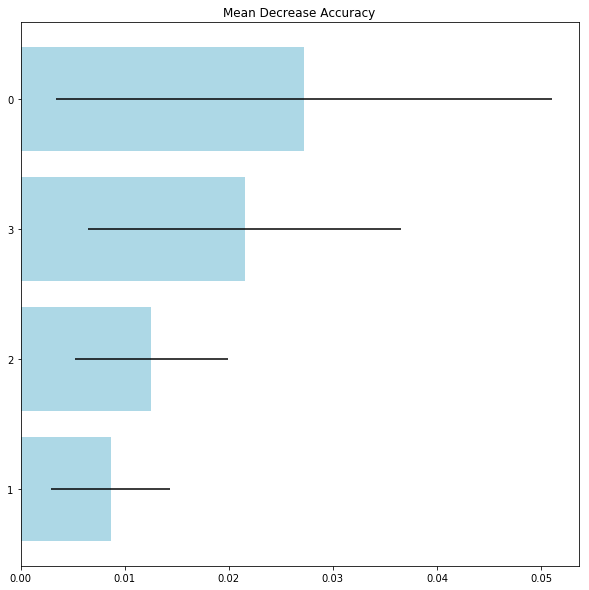

In [85]:
x_cols = [0, 1, 2, 3]

rf = ExtraTreesRegressor(n_estimators=1000, max_depth=None, 
                           random_state=0)#, min_samples_split=10)
dscores = calc_mda(rf, Xprime, y, folds=10, metric_fn=metrics.r2_score, 
                   score_fn=permutate_and_score)
stats = calc_stats(dscores, x_cols)  
hbar_plot(stats['mean'], stats['std'], stats.index, 'Mean Decrease Accuracy')

In [62]:
from sklearn.linear_model import LassoCV
#from sklearn.datasets import make_regression
#X, y = make_regression(noise=4, random_state=0)
reg = LassoCV(cv=5, random_state=0).fit(Xprime, y)

In [64]:
reg.score(Xprime, y) 

0.0

-0.09299700467489491
-0.08822381181439654
-0.00023140805065602343
-0.21325766805232194
-0.023537272932137032
-0.02598891613029286
-0.05750711845010614
-0.016081213794380655
-0.03813827919784418
-0.1392842862653756


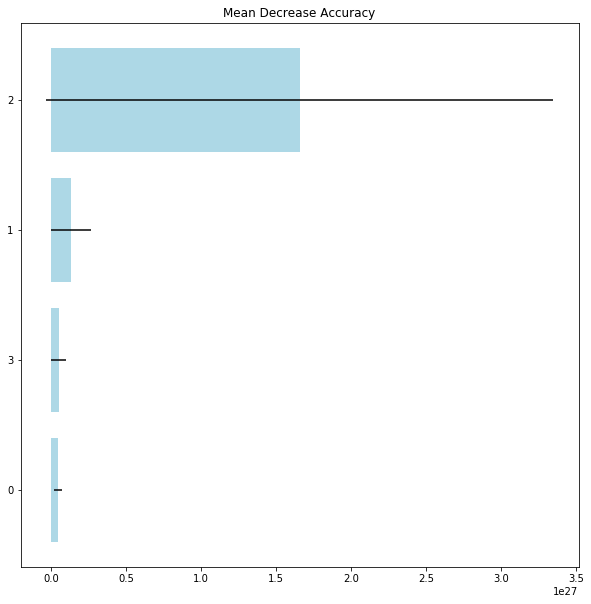

In [58]:
from sklearn.linear_model import LinearRegression
x_cols = [0, 1, 2, 3]
rf = LinearRegression()#, min_samples_split=10)
dscores = calc_mda(rf, Xprime, y, folds=10, metric_fn=metrics.r2_score, 
                   score_fn=permutate_and_score)
stats = calc_stats(dscores, x_cols)  
hbar_plot(stats['mean'], stats['std'], stats.index, 'Mean Decrease Accuracy')

In [10]:
np.random.normal(100, 2).shape

AttributeError: 'float' object has no attribute 'shape'

In [2]:
from sklearn.datasets import load_iris
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score